<a href="https://colab.research.google.com/github/BullDF/JSC270_HW2_2022_YMENG/blob/main/Assignment2_YMENG.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Import Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

### Import Data

In [35]:
# path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
# income94 = pd.read_csv(path, header=False)

# Import data directly because I worked on VSCode and I couldn't resolve the certificate error arised from accessing the link
income94 = pd.read_csv('adult.data', header=None)
income94.columns = ['age','workclass', 'fnlwgt','education','education_num','marital_status','occupation',
                    'relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','gross_income_group']

In [36]:
income94.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,gross_income_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Part II - Data Analysis

## Initial Data Exploration

### 1) Check the columns of your data.

In [37]:
income94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 32561 non-null  int64 
 1   workclass           32561 non-null  object
 2   fnlwgt              32561 non-null  int64 
 3   education           32561 non-null  object
 4   education_num       32561 non-null  int64 
 5   marital_status      32561 non-null  object
 6   occupation          32561 non-null  object
 7   relationship        32561 non-null  object
 8   race                32561 non-null  object
 9   sex                 32561 non-null  object
 10  capital_gain        32561 non-null  int64 
 11  capital_loss        32561 non-null  int64 
 12  hours_per_week      32561 non-null  int64 
 13  native_country      32561 non-null  object
 14  gross_income_group  32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


The data types for this data frame are generally correct as per the column description. More specifically, categorical variables have type `object` and continuous variables have type `int64`. The only thing I can argue is that we might convert some of the numerical variables into type `float64` since they are continuous, but this is not necessary because we have integer values for all those variables in all rows.

### 2) How are missing values represented in this data?

In [44]:
income94['marital_status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

As I was attempting to find missing values, I was surprised to see that all string values have a redundant preceding space. Thus, the following code removes the space.

In [48]:
income94.replace(r' ', '', regex=True, inplace=True)

In [50]:
income94['marital_status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

From the text file description, missing values are marked with `"?"`. The following code replaces `"?"` with `np.nan`.

In [55]:
income94.replace('?', np.nan, inplace=True)

In [64]:
income94.isna().sum()

age                      0
workclass             1836
fnlwgt                   0
education                0
education_num            0
marital_status           0
occupation            1843
relationship             0
race                     0
sex                      0
capital_gain             0
capital_loss             0
hours_per_week           0
native_country         583
gross_income_group       0
dtype: int64

There are 1836 missing values in the column `workclass`, 1843 in `occupation`, and 583 in `native_country`. Overall, there are 2399 rows with missing values. This is written in the text file description (i.e. 32651 before removing missing values and 30162 after). The following code confirms the description.

In [66]:
len(income94.dropna(axis=0))

30162

### 3) Individually plot the distributions of `capital_gain` and `capital_loss`.

Since `capital_gain` and `capital_loss` are numerical variables, we can use a histogram to plot the distribution.

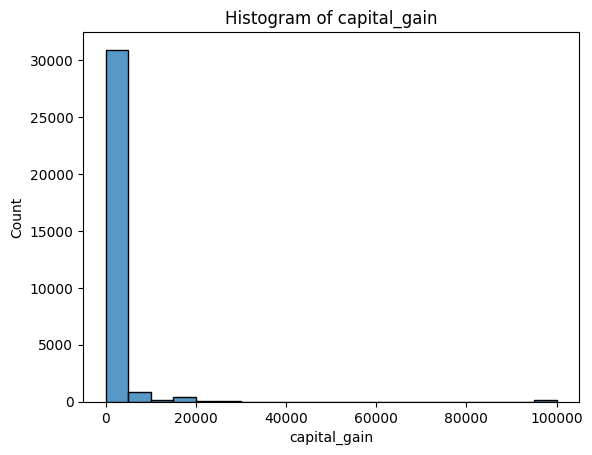

In [74]:
sns.histplot(income94, x='capital_gain', binwidth=5000)
plt.title('Histogram of capital_gain')
plt.show()

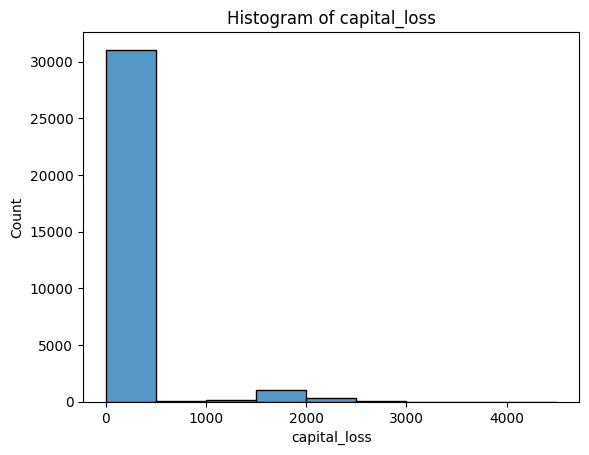

In [78]:
sns.histplot(income94, x='capital_loss', binwidth=500)
plt.title('Histogram of capital_loss')
plt.show()

It's very interesting that `capital_gain` and `capital_loss` have the majority of the data at 0. This is probably an indication of missing data in these numerical variables. Hence, I think it is helpful to convert these numerical variables into categorical variables by classifying them into a specific range. The following code creates the two new columns.

In [82]:
def range_group(value: int, ticks: list[int]) -> str:
    for i in range(len(ticks) - 1):
        lower_bound, upper_bound = ticks[i], ticks[i + 1]
        if lower_bound <= value < upper_bound:
            return f'[{lower_bound}, {upper_bound})'
        
capital_gain_ticks = list(range(0, 100001, 5000))
capital_loss_ticks = list(range(0, 5001, 500))

In [88]:
income94['capital_gain_group'] = income94['capital_gain'].apply(range_group, ticks=capital_gain_ticks)
income94['capital_loss_group'] = income94['capital_loss'].apply(range_group, ticks=capital_loss_ticks)
income94.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,gross_income_group,capital_gain_group,capital_loss_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,"[0, 5000)","[0, 500)"
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,"[0, 5000)","[0, 500)"
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,"[0, 5000)","[0, 500)"
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,"[0, 5000)","[0, 500)"
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,"[0, 5000)","[0, 500)"


In [86]:
income94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 32561 non-null  int64 
 1   workclass           30725 non-null  object
 2   fnlwgt              32561 non-null  int64 
 3   education           32561 non-null  object
 4   education_num       32561 non-null  int64 
 5   marital_status      32561 non-null  object
 6   occupation          30718 non-null  object
 7   relationship        32561 non-null  object
 8   race                32561 non-null  object
 9   sex                 32561 non-null  object
 10  capital_gain        32561 non-null  int64 
 11  capital_loss        32561 non-null  int64 
 12  hours_per_week      32561 non-null  int64 
 13  native_country      31978 non-null  object
 14  gross_income_group  32561 non-null  object
 15  capital_gain_group  32561 non-null  object
 16  capital_loss_group  32

The following tables show the categories of the newly created variables and the counts, obtained from calling `value_counts()`.

|`capital_gain_group`| count |
|--------------------|-------|
|[0, 5000)| 30913 |
|[5000, 10000)| 878 |
|[10000, 15000)| 157 |
|[15000, 20000)| 360 |
|[20000, 25000)| 38 |
|[25000, 30000)| 49 |
|[30000, 35000)| 5 |
|[40000, 45000)| 2 |
|[95000, 100000)| 159 |

|`capital_loss_group`| count |
|--------------------|-------|
|[0, 500)| 31053 |
|[500, 1000)| 25 |
|[1000, 1500)| 100 |
|[1500, 2000)| 1058 |
|[2000, 2500)| 281 |
|[2500, 3000)| 33 |
|[3000, 3500)| 2 |
|[3500, 4000)| 6 |
|[4000, 4500)| 3 |

The tables confirm with the preprocessed data that there are a lot of rows with values less than 5000 for `capital_gain` and 500 for `capital_loss`. However, by abandoning specific values and adopting groups, the analysis might become more suggestive because all groups are more meaningful and having a value of 0 like before.

### 4) Plot or numerically explore the distribution of `fnlwgt`.

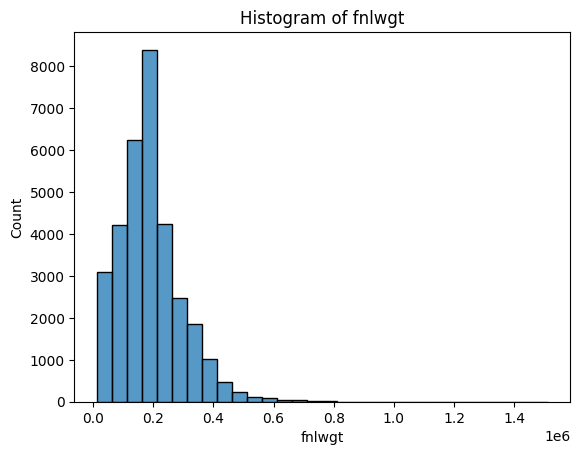

In [105]:
sns.histplot(income94, x='fnlwgt', binwidth=50000)
plt.title('Histogram of fnlwgt')
plt.show()

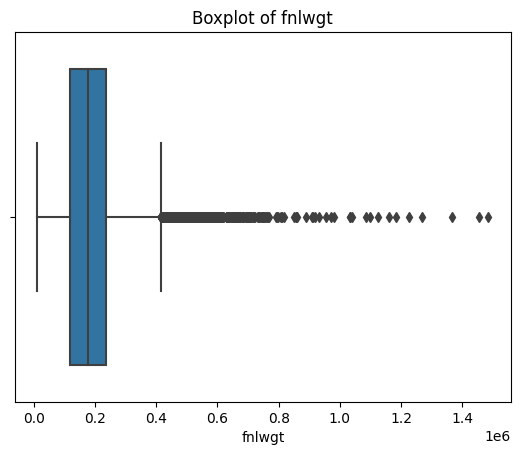

In [107]:
sns.boxplot(income94, x='fnlwgt')
plt.title('Boxplot of fnlwgt')
plt.show()

From the histogram and the boxplot, it is clear that the data for `fnlwgt` is right-skewed, with some observations having large `fnlwgt` values. The boxplot also identified many outliers using the 1.5*IQR rule. We can also plot the distribution by differentiating men and women using the following code.

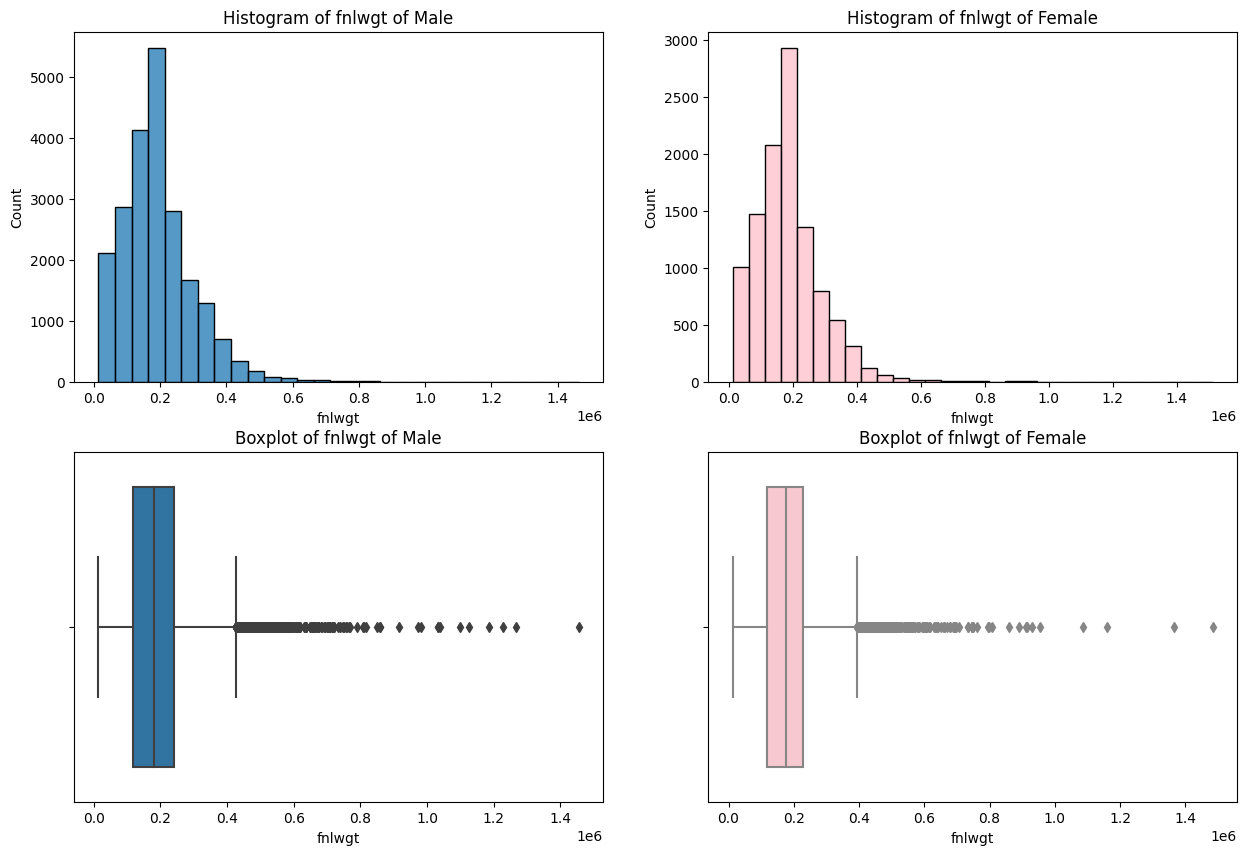

In [119]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(income94[income94['sex'] == 'Male'], x='fnlwgt', ax=axs[0, 0], binwidth=50000)
axs[0, 0].set_title('Histogram of fnlwgt of Male')

sns.histplot(income94[income94['sex'] == 'Female'], x='fnlwgt', ax=axs[0, 1], binwidth=50000, color='pink')
axs[0, 1].set_title('Histogram of fnlwgt of Female')

sns.boxplot(income94[income94['sex'] == 'Male'], x='fnlwgt', ax=axs[1, 0])
axs[1, 0].set_title('Boxplot of fnlwgt of Male')

sns.boxplot(income94[income94['sex'] == 'Female'], x='fnlwgt', ax=axs[1, 1], color='pink')
axs[1, 1].set_title('Boxplot of fnlwgt of Female')

plt.show()

From these graphs, we can see no obvious distinction between the distribution of fnlwgt for male and that for female. Both distributions are right-skewed with a peak centered at around 200000. Both exhibit some outliers as per the 1.5*IQR rule according to the boxplots.

Overall, I would not exclude the outliers identified by the boxplots from my analysis. The main reason is that the outliers are not individual. In other words, there are many points outside the maximum whisker, not just one. Thus, it is a systematic pattern that `fnlwgt` is outside the *normal* range, so we shouldn't exclude some values just because we want the analysis to look good.